In [1]:
%config IPCompleter.greedy=True
%matplotlib notebook
import libs.lib as lib
lib.setup_logger('info', logfile='/home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.log')
import apercal

root - INFO : Logging started!
root - INFO : To see the log in a bash window use the following command:
root - INFO : tail -n +1 -f /home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.log


Setup logger with lib.setup_logger()


In [3]:
prepare = apercal.prepare('/home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg')
prepare.go()

PREPARE - INFO : ### Configuration file /home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg successfully read! ###
PREPARE - INFO : ########## Preparing data for calibration ##########
PREPARE - INFO : ### Flux calibrator dataset found. Copying beam 00 to working directory. ###
PREPARE - WARNING : ### No polarisation calibrator dataset specified. The next steps might not work! ###
PREPARE - INFO : ########## Data prepared for calibration ##########


In [4]:
preflag = apercal.preflag('/home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg')
nchannel = 11008

# Make lists of the channels which are affected
a = range(0, nchannel, 64) # the subband edges
b = range(1, nchannel, 64)
c = range(63, nchannel, 64)
d = range(16, nchannel, 64) # the two ghosts
e = range(48, nchannel, 64)
# Combine the channel list into one list and convert to a string
l = a + b + c + d + e
preflag.preflag_manualflag_channel = ';'.join(str(ch) for ch in l)

preflag.manualflag()

In [5]:
preflag.aoflagger_bandpass()

TypeError: a float is required

In [6]:
preflag.aoflagger_flag()

In [7]:
convert = apercal.convert('/home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg')
convert.go()

CONVERT - INFO : ### Configuration file /home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg successfully read! ###
CONVERT - INFO : ########## FILE CONVERSION started ##########
CONVERT - INFO : ### Starting conversion from MS to UVFITS format ###
CONVERT - INFO : ### Converted MS file 3C286.MS to UVFITS format! ###
CONVERT - INFO : ### Conversion from MS to UVFITS format done! ###
CONVERT - INFO : ### Starting conversion from UVFITS to MIRIAD format ###
CONVERT - INFO : ### Converted UVFITS file 3C286.MS to MIRIAD format! ###
CONVERT - INFO : ### Conversion from UVFITS to MIRIAD format done! ###
CONVERT - INFO : ########## FILE CONVERSION done ##########


In [2]:
ccal = apercal.ccal('/home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg')

CROSSCAL - INFO : ### Configuration file /home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg successfully read! ###


In [9]:
# Set the parameters for the bandpass calibration
gainint = '60' # Solution interval for calibrator gains
gapint = '60' # Maximum time gap in data until a new solution interval starts
bpint = '60' # Solution interval for the bandpass

# Execute the bandpass calibration
mfcal = lib.miriad('mfcal')
mfcal.vis = ccal.fluxcal
# Comment the next line out if you don't want to solve for delays
mfcal.options = 'delay'
mfcal.stokes = 'XX'
mfcal.interval = gainint + ',' + gapint + ',' + bpint
mfcal.go()

['MfCal: $Revision: 1.20 $, $Date: 2017/05/08 02:31:10 $',
 'Reading the data ...',
 'Number correlations accepted: 50011451',
 'Number of frequency bands/settings: 1',
 'Number of polarisations selected: 1',
 'Number of solution intervals: 12',
 'Number of passband solution intervals: 12',
 'Initialising ...',
 'Generating initial solution estimate ...',
 'Doing solution refinement ...',
 'Iter= 1, Solution Error:  0.534',
 'Iter= 2, Solution Error:  1.000',
 'Iter= 3, Solution Error:  0.138',
 'Iter= 4, Solution Error:  0.124',
 'Iter= 5, Solution Error:  0.099',
 'Iter= 6, Solution Error:  0.096',
 'Iter= 7, Solution Error:  0.093',
 'Iter= 8, Solution Error:  0.096',
 'Iter= 9, Solution Error:  0.098',
 'Iter=10, Solution Error:  0.094',
 'Iter=11, Solution Error:  0.107',
 'Iter=12, Solution Error:  0.105',
 'Iter=13, Solution Error:  0.099',
 'Iter=14, Solution Error:  0.091',
 'Iter=15, Solution Error:  0.092',
 'Iter=16, Solution Error:  0.092',
 'Iter=17, Solution Error:  0.09

In [74]:
import subs.readmirlog
values, freqs = subs.readmirlog.get_bp(ccal.crosscaldir + '/' + ccal.fluxcal)
# The bandpass results are ordered in a 3D numpy array now called values in the following order: antenna, frequency, solution interval
# freqs gives you a list of the frequencies

<IPython.core.display.Javascript object>


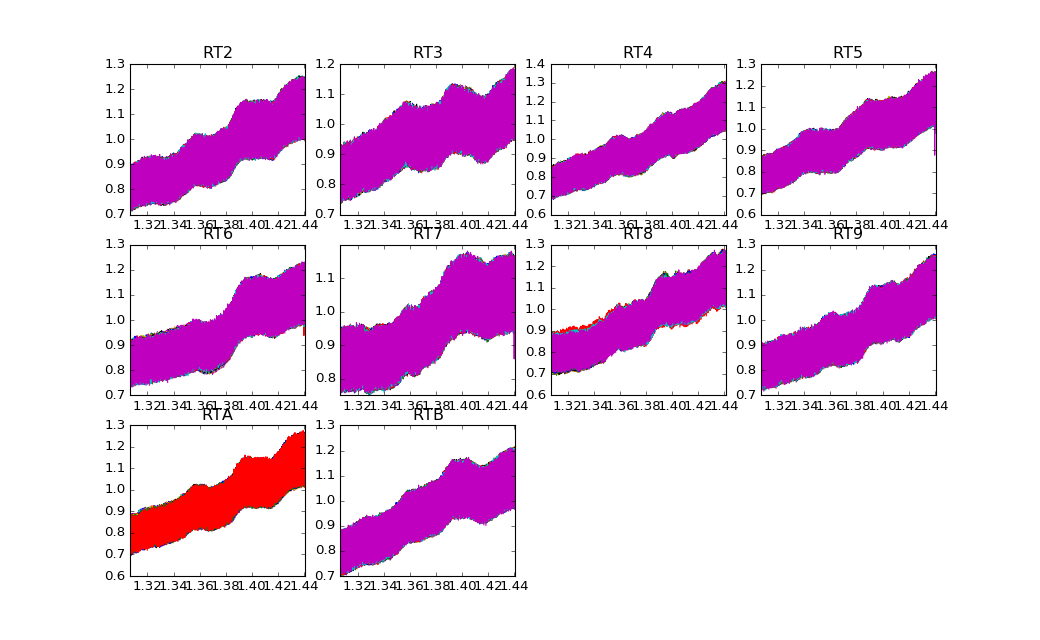

In [116]:
# You can plot all solution intervals for each antenna in one subplot each
from matplotlib import pyplot as plt
import numpy as np
values[values==0] = np.nan # Replace all zeros with nan
plt.figure(figsize=(13,8))
plt.xlim(np.min(freqs),np.max(freqs)) # Limit the plot to the minimum and maximum frequencies
# Define an array with the telescope names
tnames = ['RT2','RT3','RT4','RT5','RT6','RT7','RT8','RT9','RTA','RTB']

for a in range(len(values[:])):
    plt.subplot(3, 4, a+1)
    plt.plot(freqs, values[a,:,:])
    plt.title(tnames[a])
    plt.xlim(np.min(freqs),np.max(freqs)) # Limit the plot to the minimum and maximum freqeuncies
    plt.show()

<IPython.core.display.Javascript object>


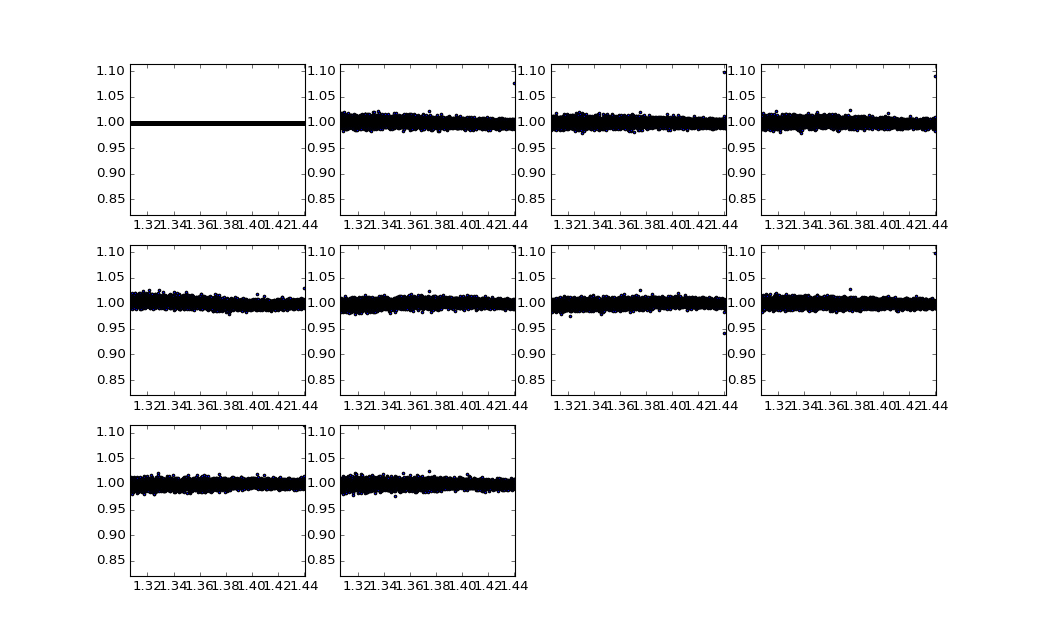

In [123]:
# Divide all solutions by the first solution interval to normalise
div = np.dstack([values[:,:,0]] * len(values[0,0]))
normvalues = values/div
# Then show the solutions for all solution intervals of one antenna
antenna = 'RT5' # You can change this one as you want
t = tnames.index(antenna)
plt.figure(figsize=(13,8))
for s in range(len(normvalues[:,:])):
    plt.subplot(3, 4, s+1)
    plt.scatter(freqs, normvalues[t,:,s],marker='.')
    plt.xlim(np.min(freqs),np.max(freqs)) # Limit the plot to the minimum and maximum freqeuncies
    plt.ylim(np.nanmin(normvalues),np.nanmax(normvalues))
    plt.show()

<IPython.core.display.Javascript object>


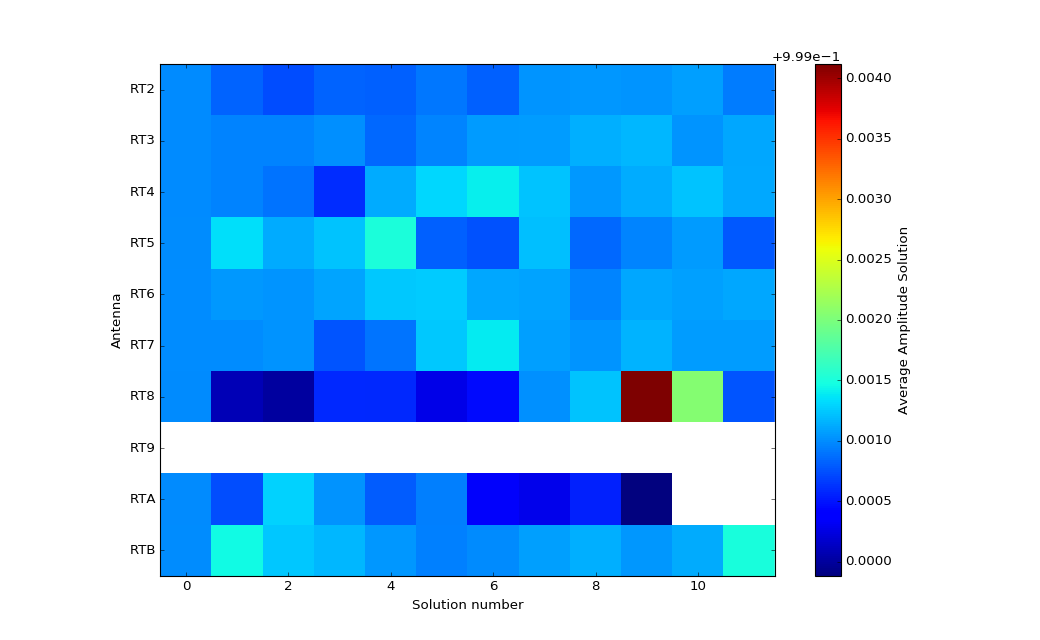

In [142]:
# Calculate the average over the freqeucny axis for each antenna and solution interval and visualise it in a plot
antaver = np.nanmean(normvalues,axis=1)
plt.figure(figsize=(13,8))
plt.imshow(antaver, interpolation='none')
plt.xlabel('Solution number')
plt.ylabel('Antenna')
plt.colorbar(label='Average Amplitude Solution')
plt.gca().set_yticks(range(len(tnames)))
plt.gca().set_yticklabels(tnames)
plt.show()

<IPython.core.display.Javascript object>


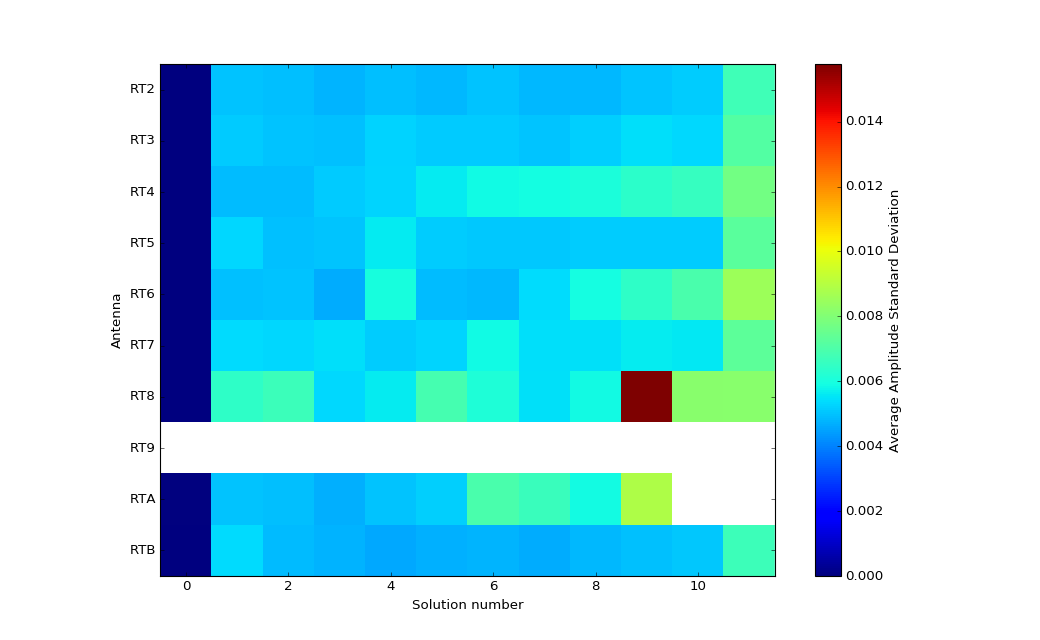

In [143]:
# Calculate the standard deviation over the freqeucny axis for each antenna and solution interval and visualise it in a plot
antstd = np.nanstd(normvalues,axis=1)
plt.figure(figsize=(13,8))
plt.imshow(antstd, interpolation='none')
plt.xlabel('Solution number')
plt.ylabel('Antenna')
plt.colorbar(label='Average Amplitude Standard Deviation')
plt.gca().set_yticks(range(len(tnames)))
plt.gca().set_yticklabels(tnames)
plt.show()

<IPython.core.display.Javascript object>


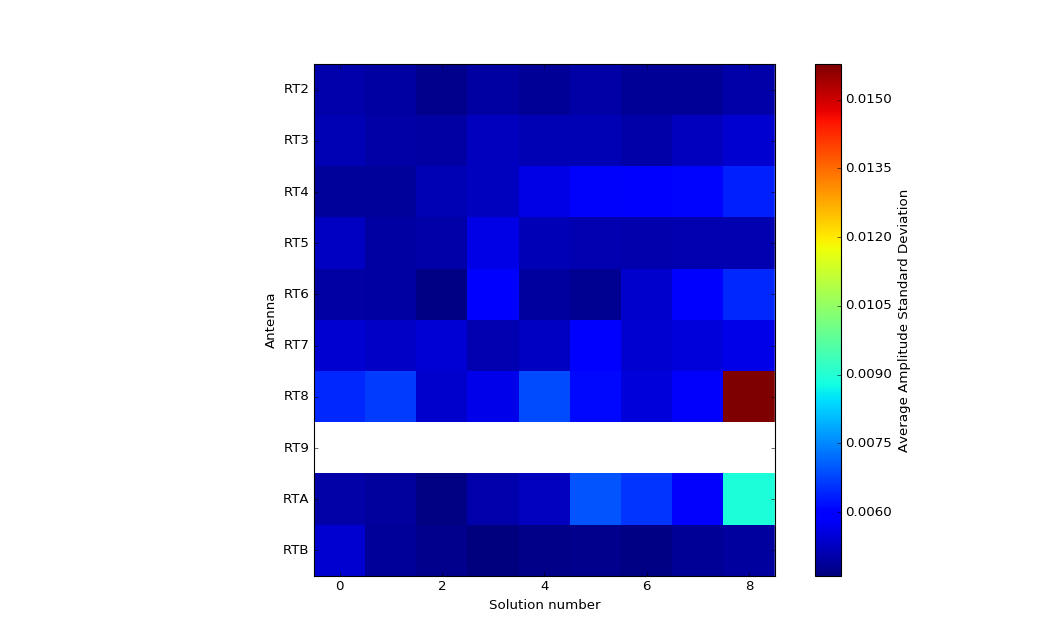

In [144]:
# If we exclude the first solution interval (it is the one we normalised with) and the last one (it is not a full one) we can make a plot with more contrast
antstd_noflsol = np.nanstd(normvalues[:,:,1:10],axis=1)
plt.figure(figsize=(13,8))
plt.imshow(antstd_noflsol, interpolation='none')
plt.xlabel('Solution number')
plt.ylabel('Antenna')
plt.colorbar(label='Average Amplitude Standard Deviation')
plt.gca().set_yticks(range(len(tnames)))
plt.gca().set_yticklabels(tnames)
plt.show()

<IPython.core.display.Javascript object>


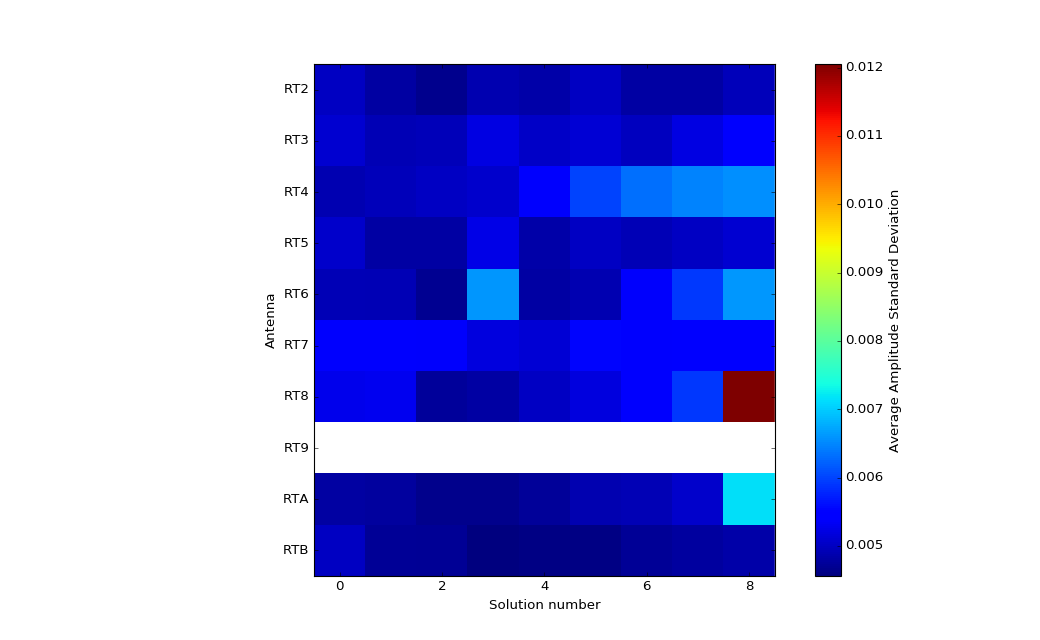

In [145]:
# It seems also be helpful to exclude the band edges
antstd_noedge = np.nanstd(normvalues[:,3000:8000,1:10],axis=1)
plt.figure(figsize=(13,8))
plt.imshow(antstd_noedge, interpolation='none')
plt.xlabel('Solution number')
plt.ylabel('Antenna')
plt.colorbar(label='Average Amplitude Standard Deviation')
plt.gca().set_yticks(range(len(tnames)))
plt.gca().set_yticklabels(tnames)
plt.show()